# Project - ML for cyber security
> **Goal:** design a backdoor detector for BadNets trained  on the YouTube Face dataset.  
**Method:** STRIP + Fine-pruning  
**Team members:** Yingzheng Wang, Rui li, Zehua Zhou, Hongjian Su  
**Submission date:** Dec 21, 2020  

## Intruduction  


To mitigate the attacks from BadNets, we apply two methods to our backdoor detector to get a better detector:  
- **STRIP:** STRong Intentional Pertubation [[source]](https://arxiv.org/abs/1902.06531)
- **Fine-pruning:** Pruning + Fine-tune [[source]](https://arxiv.org/abs/1805.12185)

## **STRIP**

## **Fine-pruning**

### Configure the environment

In [ ]:
!pip install tensorflow_model_optimization
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import necessary packages

In [ ]:
import tempfile
import os
import tensorflow as tf
from tensorflow import keras
import h5py
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K

%load_ext tensorboard

### Declare common functions and variables

In [ ]:
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))
    return x_data, y_data

def data_preprocess(x_data):
    return x_data/255

clean_data_filename = str('/content/drive/MyDrive/cyberSecurity/clean_validation_data.h5')
test_data_filename = str('/content/drive/MyDrive/cyberSecurity/clean_test_data.h5')
train_images, train_labels=data_loader(clean_data_filename)
train_images=data_preprocess(train_images)
print("Shape of train_images: {0}".format(train_images.shape))
print("Shape of train_labels: {0}".format(train_labels.shape))

tune_images, tune_labels=data_loader(clean_data_filename)
tune_images=data_preprocess(tune_images)

import tensorflow_model_optimization as tfmot
prune_low_magnitude=tfmot.sparsity.keras.prune_low_magnitude
batch_size = 128
epochs_test = np.array([2, 4, 6, 8, 10])
validation_split = 0.1

# Define model for pruning.
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.8, 0),
    'block_size': (1, 1),
    'block_pooling_type': 'AVG'
}

#dense layers train with pruning
def apply_pruning_to_dense(layer):
  if layer.name in ['conv_3']:
    return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
  return layer

Shape of train_images: (11547, 55, 47, 3)
Shape of train_labels: (11547,)


### **BadNet: sunglasses poisoned**

#### Get the BadNet model

In [ ]:
K.clear_session()

In [ ]:
model_filename = str('/content/drive/MyDrive/cyberSecurity/models/sunglasses_bd_net.h5')
bd_model = keras.models.load_model(model_filename)
bd_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 55, 47, 3)]  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 52, 44, 20)   980         input[0][0]                      
__________________________________________________________________________________________________
pool_1 (MaxPooling2D)           (None, 26, 22, 20)   0           conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 24, 20, 40)   7240        pool_1[0][0]                     
____________________________________________________________________________________________

#### Fetch poisoned data

In [ ]:
sunglasses_data_filename = str('/content/drive/MyDrive/cyberSecurity/sunglasses_poisoned_data.h5')

#### Implement pruning

In [ ]:
model_for_pruning=tf.keras.models.clone_model(
    bd_model,
    clone_function=apply_pruning_to_dense,
)
model_for_pruning.compile(optimizer='adam',
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=['accuracy'])
model_for_pruning.summary()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 55, 47, 3)]  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 52, 44, 20)   980         input[0][0]                      
__________________________________________________________________________________________________
pool_1 (MaxPooling2D)           (None, 26, 22, 20)   0           conv_1[1][0]                     
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 24, 20, 40)   7240        pool_1[1][0]                     
____________________________________________________________________________________________

#### Implement Fine-tuning +  Cross validation

In [ ]:
#train and evaluate the model against baseline -- fine-tuning
logdir = tempfile.mkdtemp()
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

clean_accuracy = np.zeros(epochs_test.shape[0])
poison_accuracy = np.zeros(epochs_test.shape[0])
for i, epochs in enumerate(epochs_test):
  model_for_pruning.fit(tune_images, tune_labels,
                    batch_size=batch_size, epochs=epochs, 
                    callbacks=callbacks, verbose=0)
  #test clean data accuracy
  test_images, test_labels = data_loader(test_data_filename)
  test_images=data_preprocess(test_images)
  _, model_for_pruning_accuracy = model_for_pruning.evaluate(
    test_images, test_labels, verbose=0)
  clean_accuracy[i] = model_for_pruning_accuracy
  print('Epochs={0} (clean data) - pruned test accuracy: {1}'.format(epochs, model_for_pruning_accuracy))
  #test poison data accuracy
  test_images, test_labels = data_loader(sunglasses_data_filename)
  test_images=data_preprocess(test_images)
  _, model_for_pruning_accuracy = model_for_pruning.evaluate(
    test_images, test_labels, verbose=0)
  poison_accuracy[i] = model_for_pruning_accuracy
  print('Epochs={0} (poisoned data) - attack success rate: {1}'.format(epochs, model_for_pruning_accuracy))

Epochs=2 (clean data) - pruned test accuracy: 0.9353858232498169
Epochs=2 (poisoned data) - attack success rate: 0.773499608039856
Epochs=4 (clean data) - pruned test accuracy: 0.9106001853942871
Epochs=4 (poisoned data) - attack success rate: 0.5047544836997986
Epochs=6 (clean data) - pruned test accuracy: 0.9134060740470886
Epochs=6 (poisoned data) - attack success rate: 0.18121589720249176
Epochs=8 (clean data) - pruned test accuracy: 0.8984411358833313
Epochs=8 (poisoned data) - attack success rate: 0.027591582387685776
Epochs=10 (clean data) - pruned test accuracy: 0.9134840369224548
Epochs=10 (poisoned data) - attack success rate: 0.02431800402700901


#### Visualize the results

Text(0, 0.5, 'attack success rate')

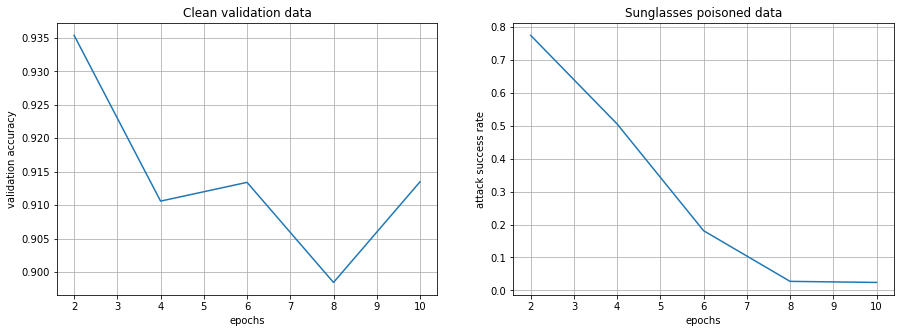

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_test, clean_accuracy)
plt.title('Clean validation data')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('validation accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_test, poison_accuracy, label='Poison')
plt.title('Sunglasses poisoned data')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('attack success rate')

### **BadNet: anonymous1 poisoned**



#### Get the BadNet model

In [ ]:
K.clear_session()

In [ ]:
model_filename = str('/content/drive/MyDrive/cyberSecurity/models/anonymous_1_bd_net.h5')
bd_model = keras.models.load_model(model_filename)
bd_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 55, 47, 3)]  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 52, 44, 20)   980         input[0][0]                      
__________________________________________________________________________________________________
pool_1 (MaxPooling2D)           (None, 26, 22, 20)   0           conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 24, 20, 40)   7240        pool_1[0][0]                     
____________________________________________________________________________________________

#### Fetch poisoned data

In [ ]:
anonymous_data_filename = str('/content/drive/MyDrive/cyberSecurity/anonymous_1_poisoned_data.h5')

#### Implement pruning

In [ ]:
model_for_pruning=tf.keras.models.clone_model(
    bd_model,
    clone_function=apply_pruning_to_dense,
)
model_for_pruning.compile(optimizer='adam',
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=['accuracy'])
model_for_pruning.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 55, 47, 3)]  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 52, 44, 20)   980         input[0][0]                      
__________________________________________________________________________________________________
pool_1 (MaxPooling2D)           (None, 26, 22, 20)   0           conv_1[1][0]                     
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 24, 20, 40)   7240        pool_1[1][0]                     
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


#### Implement Fine-tuning +  Cross validation

In [ ]:
#train and evaluate the model against baseline -- fine-tuning
logdir = tempfile.mkdtemp()
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

clean_accuracy = np.zeros(epochs_test.shape[0])
poison_accuracy = np.zeros(epochs_test.shape[0])
for i, epochs in enumerate(epochs_test):
  model_for_pruning.fit(tune_images, tune_labels,
                    batch_size=batch_size, epochs=epochs, 
                    callbacks=callbacks, verbose=0)
  #test clean data accuracy
  test_images, test_labels = data_loader(test_data_filename)
  test_images=data_preprocess(test_images)
  _, model_for_pruning_accuracy = model_for_pruning.evaluate(
    test_images, test_labels, verbose=0)
  clean_accuracy[i] = model_for_pruning_accuracy
  print('Epochs={0} (clean data) - pruned test accuracy: {1}'.format(epochs, model_for_pruning_accuracy))
  #test poison data accuracy
  test_images, test_labels = data_loader(anonymous_data_filename)
  test_images=data_preprocess(test_images)
  _, model_for_pruning_accuracy = model_for_pruning.evaluate(
    test_images, test_labels, verbose=0)
  poison_accuracy[i] = model_for_pruning_accuracy
  print('Epochs={0} (poisoned data) - attack success rate: {1}'.format(epochs, model_for_pruning_accuracy))

Epochs=2 (clean data) - pruned test accuracy: 0.9579111337661743
Epochs=2 (poisoned data) - attack success rate: 0.8388542532920837
Epochs=4 (clean data) - pruned test accuracy: 0.9574434757232666
Epochs=4 (poisoned data) - attack success rate: 0.8412899374961853
Epochs=6 (clean data) - pruned test accuracy: 0.9305533766746521
Epochs=6 (poisoned data) - attack success rate: 0.6059041023254395
Epochs=8 (clean data) - pruned test accuracy: 0.9279033541679382
Epochs=8 (poisoned data) - attack success rate: 0.5438425540924072
Epochs=10 (clean data) - pruned test accuracy: 0.9418550133705139
Epochs=10 (poisoned data) - attack success rate: 0.5500779151916504


#### Visualize the results

Text(0, 0.5, 'attack success rate')

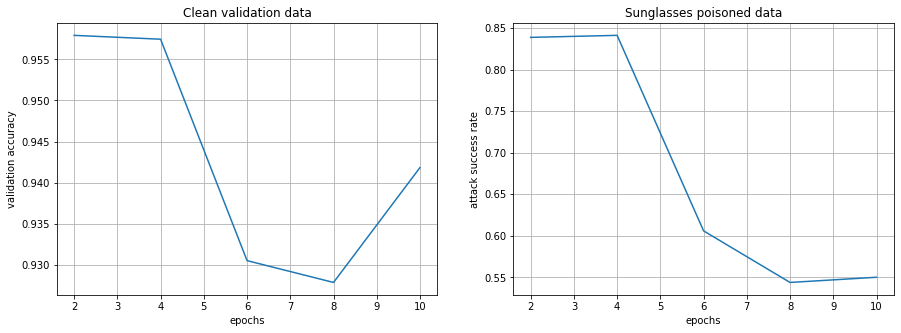

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_test, clean_accuracy)
plt.title('Clean validation data')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('validation accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_test, poison_accuracy, label='Poison')
plt.title('Sunglasses poisoned data')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('attack success rate')

### **BadNet: anonymous2 poisoned**

### **BadNet: multi trigger & multi target poisoned**

In [ ]:
K.clear_session()

In [ ]:
model_filename = str('/content/drive/MyDrive/cyberSecurity/models/multi_trigger_multi_target_bd_net.h5')
bd_model = keras.models.load_model(model_filename)
bd_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 55, 47, 3)]  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 52, 44, 20)   980         input[0][0]                      
__________________________________________________________________________________________________
pool_1 (MaxPooling2D)           (None, 26, 22, 20)   0           conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 24, 20, 40)   7240        pool_1[0][0]                     
____________________________________________________________________________________________

In [ ]:
# multi_data_filename = str('/content/drive/MyDrive/cyberSecurity/Multi-trigger Multi-target/eyebrows_poisoned_data.h5')
multi_data_filename = str('/content/drive/MyDrive/cyberSecurity/Multi-trigger Multi-target/lipstick_poisoned_data.h5')
# multi_data_filename = str('/content/drive/MyDrive/cyberSecurity/Multi-trigger Multi-target/sunglasses_poisoned_data.h5')

In [ ]:
model_for_pruning=tf.keras.models.clone_model(
    bd_model,
    clone_function=apply_pruning_to_dense,
)
model_for_pruning.compile(optimizer='adam',
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=['accuracy'])
model_for_pruning.summary()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 55, 47, 3)]  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 52, 44, 20)   980         input[0][0]                      
__________________________________________________________________________________________________
pool_1 (MaxPooling2D)           (None, 26, 22, 20)   0           conv_1[1][0]                     
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 24, 20, 40)   7240        pool_1[1][0]                     
____________________________________________________________________________________________

In [ ]:
#train and evaluate the model against baseline -- fine-tuning
logdir = tempfile.mkdtemp()
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

clean_accuracy = np.zeros(epochs_test.shape[0])
poison_accuracy = np.zeros(epochs_test.shape[0])
for i, epochs in enumerate(epochs_test):
  model_for_pruning.fit(tune_images, tune_labels,
                    batch_size=batch_size, epochs=epochs, 
                    callbacks=callbacks, verbose=0)
  #test clean data accuracy
  test_images, test_labels = data_loader(test_data_filename)
  test_images=data_preprocess(test_images)
  _, model_for_pruning_accuracy = model_for_pruning.evaluate(
    test_images, test_labels, verbose=0)
  clean_accuracy[i] = model_for_pruning_accuracy
  print('Epochs={0} (clean data) - pruned test accuracy: {1}'.format(epochs, model_for_pruning_accuracy))
  #test poison data accuracy
  test_images, test_labels = data_loader(multi_data_filename)
  test_images=data_preprocess(test_images)
  _, model_for_pruning_accuracy = model_for_pruning.evaluate(
    test_images, test_labels, verbose=0)
  poison_accuracy[i] = model_for_pruning_accuracy
  print('Epochs={0} (poisoned data) - attack success rate: {1}'.format(epochs, model_for_pruning_accuracy))

Epochs=2 (clean data) - pruned test accuracy: 0.9578332304954529
Epochs=2 (poisoned data) - attack success rate: 0.8864964842796326
Epochs=4 (clean data) - pruned test accuracy: 0.9666407108306885
Epochs=4 (poisoned data) - attack success rate: 0.8907833099365234
Epochs=6 (clean data) - pruned test accuracy: 0.9288386702537537
Epochs=6 (poisoned data) - attack success rate: 0.7102494239807129
Epochs=8 (clean data) - pruned test accuracy: 0.9458301067352295
Epochs=8 (poisoned data) - attack success rate: 0.7691932916641235
Epochs=10 (clean data) - pruned test accuracy: 0.9475448131561279
Epochs=10 (poisoned data) - attack success rate: 0.7543842792510986
